In [ ]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

import os

import matplotlib.pyplot as plt
import pandas as pd
import shap
import statsmodels.api as sm
from colormaps import (
    get_continuous_cmap_lilac,
    get_continuous_cmap_white,
    get_segmented_cmap,
)
from plotting_names import plotting_names
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from utils.paths import EXTRACTED_FEATURES_DIR

/HOME/lecomteo/.conda/envs/mthesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Colour Maps
cmap_white = get_continuous_cmap_white()
cmap_lilac = get_continuous_cmap_lilac()
cmap_seg = get_segmented_cmap()

In [ ]:
# Load data
path = EXTRACTED_FEATURES_DIR / "merged_features.csv"
features_df = pd.read_csv(path)
features_df.drop(
    columns=[
        "participant_folder",
        "HASH",
        "filename_x",
        "filename_y",
        "folder",
        "n_fruits",
        "n_seen",
    ],
    inplace=True,
)
features_df.columns

Index(['group', 'mean_fix_duration', 'median_fix_duration',
       'mean_saccade_length', 'median_saccade_length', 'mean_blink_duration',
       'median_blink_duration', 'num_fixations_per_min', 'num_blinks_per_min',
       'num_saccades_per_min', 'age', 'ran_score', 'mean_fix_dist_to_object',
       'median_fix_dist_to_object', 'mean_fix_dist_to_fruit',
       'median_fix_dist_to_fruit', 'percent_fixations_outside_bbox',
       'mean_latency', 'median_latency', 'std_latency', 'max_latency',
       'percent_unseen_fruits', 'FIC_mean', 'FIC_std', 'FFD'],
      dtype='object')

In [4]:
# Regression ran_score ~ age -> using residuals bc age and ran_score are correlated but not necessarily linearly
X = features_df.select_dtypes(include="number")
X_reg = sm.add_constant(X["age"])
y = X["ran_score"]

model = sm.OLS(y, X_reg).fit()
features_df["ran_score_resid"] = model.resid

In [5]:
# Define 'good' and 'bad' groups based on median of residuals
median_resid = features_df["ran_score_resid"].median()

features_df["ran_group"] = features_df["ran_score_resid"].apply(
    lambda x: "good" if x >= median_resid else "poor"
)

In [6]:
if any(features_df.isna().sum() > 1):
    print(features_df.isna().sum())
else:
    print("No NaN values found in the dataset.")

No NaN values found in the dataset.


In [7]:
# Prepare X and y
X_full = X.drop(columns=["ran_score", "age"])
y = features_df["ran_group"].map({"good": 1, "poor": 0})

print("Number of Features:", X_full.shape[1])
print("Number of Participants: ", len(y))
summary = features_df.groupby("ran_group")["group"].value_counts()
summary

Number of Features: 22
Number of Participants:  57


ran_group  group      
good       adultspring    14
           fruitninja      9
           dyscover        6
poor       adultspring    12
           dyscover       11
           fruitninja      5
Name: count, dtype: int64

In [8]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

In [9]:
# RF
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    criterion="gini",
    max_depth=None,
    max_features="sqrt",
    bootstrap=True,
)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Importance Ranking
importances = rf.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)
plot_labels_imp = [plotting_names.get(f, f) for f in importance_df["Feature"]]

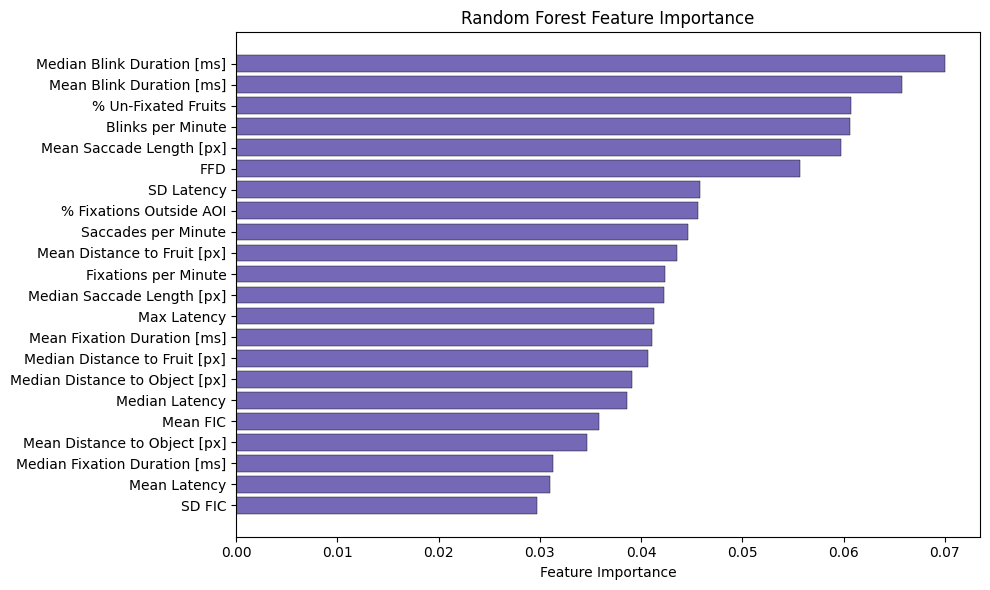

In [11]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(
    plot_labels_imp,
    importance_df["Importance"],
    color=cmap_seg[4],
    edgecolor="k",
    linewidth=0.3,
)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

In [12]:
most_important_features = importance_df[importance_df["Importance"] > 0.05].sort_values(
    by="Importance", ascending=False
)
most_important_features

,Feature,Importance
5,median_blink_duration,0.069973
4,mean_blink_duration,0.065747
18,percent_unseen_fruits,0.060749
7,num_blinks_per_min,0.060675
2,mean_saccade_length,0.059789
21,FFD,0.055673


In [13]:
explainer = shap.Explainer(rf, X_train, feature_names=X_train.columns)

# Get SHAP values (single array for binary classification)
shap_values = explainer(X_test)

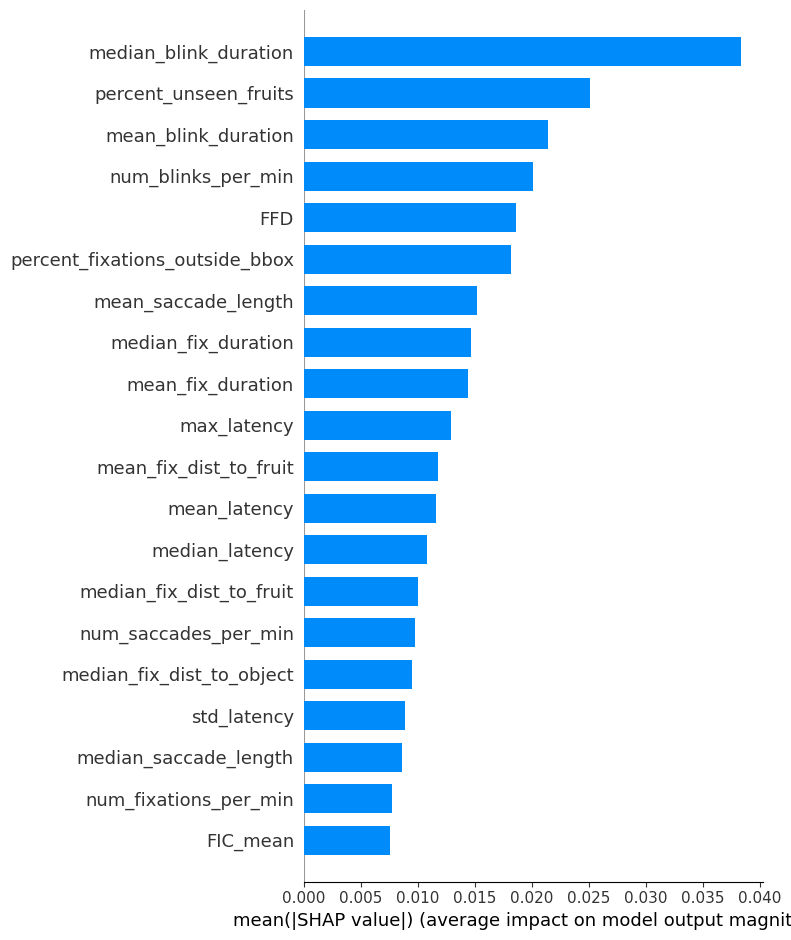

In [14]:
# Get SHAP values for class 1 ("good")
shap_good = shap_values.values[:, :, 1]

# Then plot:
shap.summary_plot(shap_good, X_test, feature_names=X_test.columns, plot_type="bar")

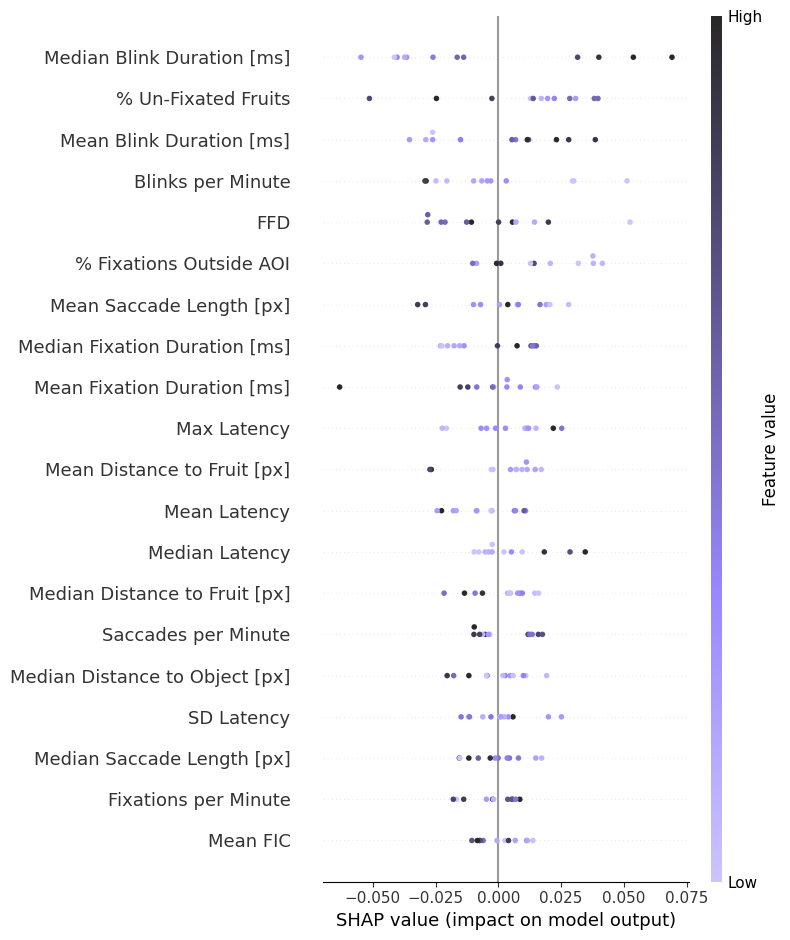

In [15]:
# Now plot
plot_labels_shap = [plotting_names.get(f, f) for f in X_test.columns]

shap.summary_plot(
    shap_good,
    X_test.to_numpy(),
    feature_names=plot_labels_shap,
    cmap=cmap_lilac,
)

**Interpreting SHAP**
SHAP assigns each feature a value that quantifies how much the feature contributed to pushing the model’s prediction away from the base rate (average prediction).

- SHAP values > 0 → push the prediction toward class 1 (“good” group)
- SHAP values < 0 → push the prediction toward class 0 (“poor” group)

SHAP analysis revealed that features such as max lentency, fixation dispersion (FFD), mean latency, and the percent of unseen fruits had the highest influence on predicting group membership. For instance, low mean latency values were consistently associated with classification into the "good" RAN group (SHAP < 0), suggesting that participants who were quicker to drect their eyes to a new fruit while playing Fruit Ninja were more likely to have a better RAN score.

In [16]:
shap.initjs()  # enables interactive JS plots

class_idx = 1  # 1 = good

for i in range(len(X_test)):
    p = shap.force_plot(
        base_value=shap_values.base_values[i, class_idx],
        shap_values=shap_values.values[i, :, class_idx],
        features=X_test.iloc[i],
        feature_names=plot_labels_shap,
        plot_cmap=[cmap_seg[4], cmap_seg[6]],
    )
    print(f"Participant {i} - Class {class_idx} SHAP Force Plot")
    display(p)

Participant 0 - Class 1 SHAP Force Plot


Participant 1 - Class 1 SHAP Force Plot


Participant 2 - Class 1 SHAP Force Plot


Participant 3 - Class 1 SHAP Force Plot


Participant 4 - Class 1 SHAP Force Plot


Participant 5 - Class 1 SHAP Force Plot


Participant 6 - Class 1 SHAP Force Plot


Participant 7 - Class 1 SHAP Force Plot


Participant 8 - Class 1 SHAP Force Plot


Participant 9 - Class 1 SHAP Force Plot


Participant 10 - Class 1 SHAP Force Plot


Participant 11 - Class 1 SHAP Force Plot


In [17]:
print("N:", len(X))
X = X.drop(columns=['ran_score'])
y = features_df["ran_score"]
print("Number of features: ", len(X.columns))
print("Features: ")
X.columns

N: 57
Number of features:  23
Features: 


Index(['mean_fix_duration', 'median_fix_duration', 'mean_saccade_length',
       'median_saccade_length', 'mean_blink_duration', 'median_blink_duration',
       'num_fixations_per_min', 'num_blinks_per_min', 'num_saccades_per_min',
       'age', 'mean_fix_dist_to_object', 'median_fix_dist_to_object',
       'mean_fix_dist_to_fruit', 'median_fix_dist_to_fruit',
       'percent_fixations_outside_bbox', 'mean_latency', 'median_latency',
       'std_latency', 'max_latency', 'percent_unseen_fruits', 'FIC_mean',
       'FIC_std', 'FFD'],
      dtype='object')

In [18]:
correlations = {}
p_values = {}

# Loop through each column (except ran_score itself)
for col in X.columns:
    corr, p = pearsonr(X[col], y)
    correlations[col] = corr
    p_values[col] = p

# Create DataFrame with both correlation and p-value
corr_results_df = pd.DataFrame({"correlation": correlations, "p_value": p_values})

# Add significance flag (e.g., p < 0.05)
corr_results_df["significant"] = corr_results_df["p_value"] < 0.05
corr_results_df["correlation"] = corr_results_df["correlation"].round(2)
corr_results_df["p_value"] = corr_results_df["p_value"].round(3)

# Sort by absolute correlation
corr_results_df = corr_results_df.reindex(
    corr_results_df["correlation"].abs().sort_values(ascending=False).index
)

# Display the results
corr_results_df

,correlation,p_value,significant
age,0.79,0.000,True
mean_saccade_length,-0.55,0.000,True
percent_unseen_fruits,-0.45,0.000,True
median_saccade_length,-0.42,0.001,True
num_blinks_per_min,-0.40,0.002,True
mean_fix_dist_to_object,-0.36,0.007,True
median_blink_duration,0.36,0.006,True
mean_blink_duration,0.35,0.007,True
mean_fix_dist_to_fruit,-0.34,0.011,True
FFD,-0.32,0.015,True


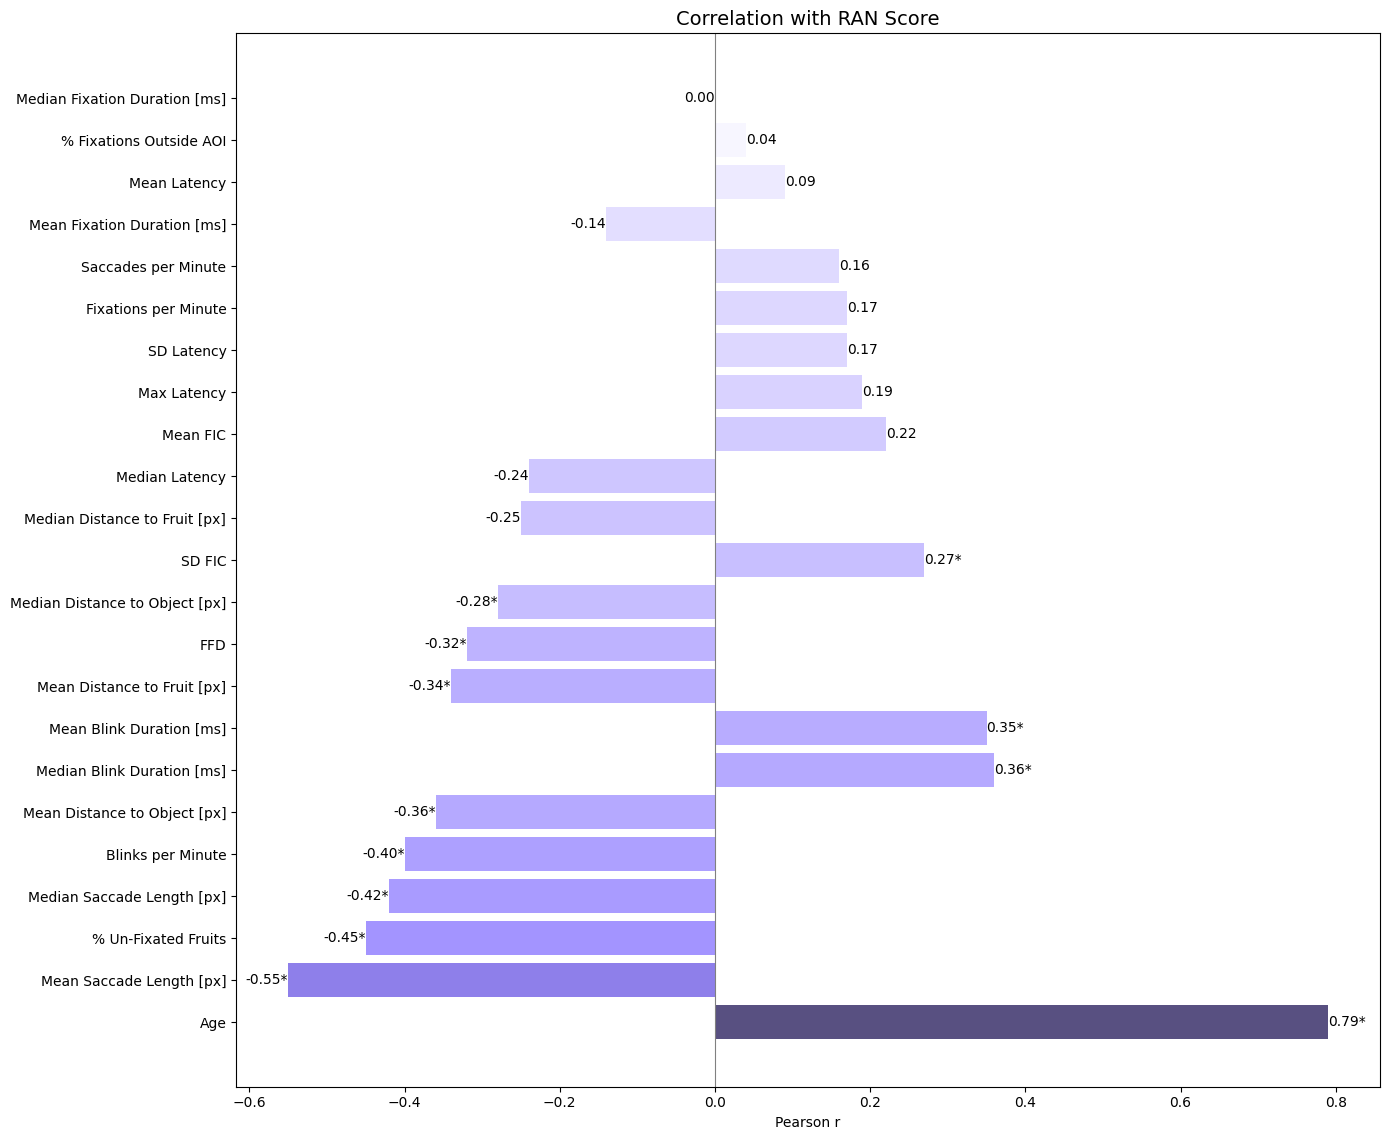

In [19]:
# Prepare values
corr_vals = corr_results_df["correlation"]
features = corr_results_df.index
significant = corr_results_df["significant"]
plot_labels = [plotting_names.get(f, f) for f in features]

# Colormap
cmap = get_continuous_cmap_white()
abs_corr_vals = corr_vals.abs()
colors = [cmap(r) for r in abs_corr_vals]

# Plot
fig, ax = plt.subplots(figsize=(14, len(features) * 0.5))
bars = ax.barh(plot_labels, corr_vals, color=colors)

# Annotate values with optional asterisk
for i, (r, sig) in enumerate(zip(corr_vals, significant)):
    text = f"{r:.2f}" + ("*" if sig else "")
    ax.text(r, i, text, va="center", ha="left" if r > 0 else "right", color="black")

# Final touches
ax.set_title("Correlation with RAN Score", fontsize=14)
ax.set_xlabel("Pearson r")
ax.axvline(0, color="gray", linewidth=0.8)
plt.tight_layout()
plt.show()

In [20]:
# Display the significant correlations
results_corr_sig = corr_results_df[corr_results_df["significant"]]
print("Number of significant correlations:", len(results_corr_sig))

Number of significant correlations: 12


In [21]:
# Define different feature sets
basic_features = [
    "mean_fix_duration",
    "median_fix_duration",
    "mean_saccade_length",
    "median_saccade_length",
]

significant_features = results_corr_sig.index.tolist()

spatial_features = [
    "FIC_mean",
    "FIC_std",
    "FFD",
]

fixation_features = [
    "mean_fix_duration",
    "median_fix_duration",
    "num_fixations_per_min",
]

saccade_features = [
    "mean_saccade_length",
    "median_saccade_length",
    "num_saccades_per_min",
]

latency_features = [
    "mean_latency",
    "median_latency",
    "std_latency",
    "max_latency",
]

blink_features = [
    "median_blink_duration",
    "mean_blink_duration",
    "num_blinks_per_min",
]

aoi_features = [
    "mean_fix_dist_to_object",
    "median_fix_dist_to_object",
    "mean_fix_dist_to_fruit",
    "median_fix_dist_to_fruit",
    "percent_fixations_outside_bbox",
    "percent_unseen_fruits",
]

most_imp_features = most_important_features["Feature"].tolist()

all_features = X.columns.tolist()

# --- Bundle sets into a dict ---
feature_sets = {
    "Basic": basic_features,
    "Significant": significant_features,
    "Spatial": spatial_features,
    "Fixation": fixation_features,
    "Saccade": saccade_features,
    "Latency": latency_features,
    "Blinks": blink_features,
    "Most Important": most_imp_features,
    "AOI": aoi_features,
    "All": all_features,
}

In [ ]:
# Save to a Python file
with open("feature_sets.py", "w") as f:
    f.write("feature_sets = ")
    f.write(repr(feature_sets))

In [ ]:
# -- SAVE AS CSV ---
output_csv_path = EXTRACTED_FEATURES_DIR / 'final_features.csv'
overwrite = False  # Set to True if you want to overwrite existing files

if not os.path.exists(output_csv_path) or overwrite:
    hash_table.to_csv(output_csv_path, index=False)
    print(f"Features saved to {output_csv_path}")

else:
    print(f"File already exists: {output_csv_path}. Not overwriting.")
